<a href="https://colab.research.google.com/github/anantpatil146/DeepLearning-Practical-/blob/main/Assingment_5_Anant_Patil_Time_Series_Forecasting_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 5.1

1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense


2. Load the Dataset

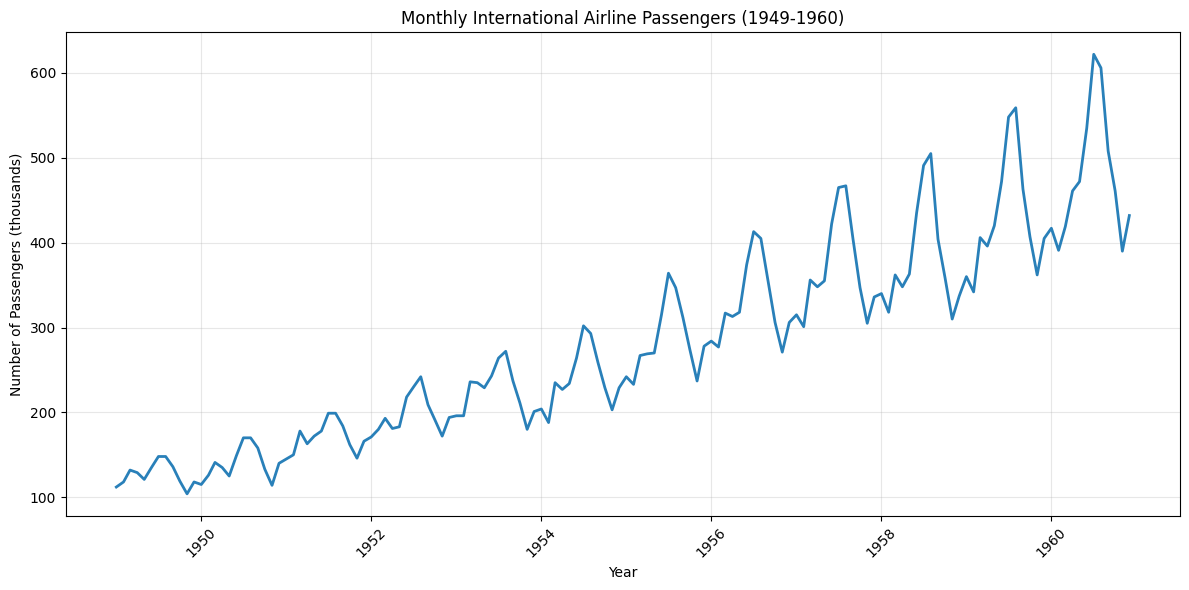

In [ ]:
# Load and prepare airline passengers data
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Create visualization
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'], linewidth=2, color='#2980b9')
plt.title("Monthly International Airline Passengers (1949-1960)")
plt.xlabel("Year")
plt.ylabel("Number of Passengers (thousands)")
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add some styling
plt.tight_layout()
plt.show()

3. Data Preprocessing

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale the passenger data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Passengers']])

def create_dataset(data, time_step=12):  # Changed to 12 for monthly data
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Create sequences using 12 months of data to predict next month
time_step = 12  # Changed to 12 for monthly predictions
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Input shape:", X.shape)
print("Output shape:", y.shape)

Input shape: (131, 12, 1)
Output shape: (131,)


4. Train-Test Split

In [ ]:
# Split data into training and testing sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print shapes to verify the split
print("Training Data:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("\nTesting Data:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Calculate actual time periods
train_months = train_size + time_step
test_months = len(X) - train_size + time_step
print(f"\nTraining period: {train_months} months")
print(f"Testing period: {test_months} months")

Training Data:
X_train shape: (104, 12, 1)
y_train shape: (104,)

Testing Data:
X_test shape: (27, 12, 1)
y_test shape: (27,)

Training period: 116 months
Testing period: 39 months


5. LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Display model summary
model.summary()

# Train the model with early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 12, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 12, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,929 (503.63 KB)

 Trainable params: 128,929 (503.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - loss: 0.0983 - mae: 0.2644 - val_loss: 0.1202 - val_mae: 0.3150
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0207 - mae: 0.1124 - val_loss: 0.0191 - val_mae: 0.1080
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0143 - mae: 0.0985 - val_loss: 0.0728 - val_mae: 0.2279
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0148 - mae: 0.0859 - val_loss: 0.0242 - val_mae: 0.1116
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0100 - mae: 0.0841 - val_loss: 0.0215 - val_mae: 0.1081
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0073 - mae: 0.0680 - val_loss: 0.0258 - val_mae: 0.1156
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0091 - mae: 0.0715 - val_loss: 0.0206 - val_mae: 0.1056


6. Model Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

# Print metrics
print(f'Root Mean Squared Error: {rmse:.2f} passengers')
print(f'Mean Absolute Error: {mae:.2f} passengers')
print(f'Mean Absolute Percentage Error: {mape:.2f}%')

# Calculate R-squared
r2 = 1 - (np.sum((y_test_inv - y_pred_inv)**2) / np.sum((y_test_inv - np.mean(y_test_inv))**2))
print(f'R-squared Score: {r2:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
Root Mean Squared Error: 71.60 passengers
Mean Absolute Error: 55.94 passengers
Mean Absolute Percentage Error: 12.45%
R-squared Score: 0.1982


7. Prediction vs Actual Plot

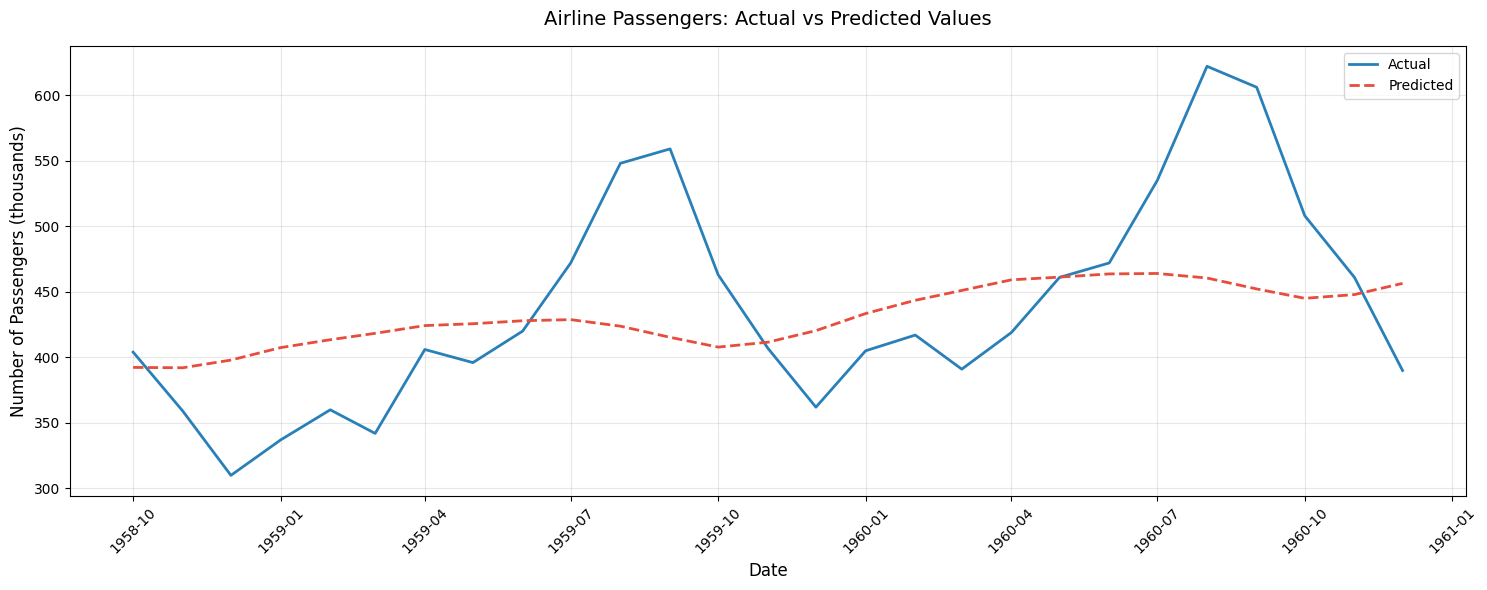

In [ ]:
plt.figure(figsize=(15, 6))

# Plot actual vs predicted values
plt.plot(df.index[-(len(y_test_inv)):], y_test_inv, label='Actual', linewidth=2, color='#2980b9')
plt.plot(df.index[-(len(y_pred_inv)):], y_pred_inv, label='Predicted', linewidth=2, color='#e74c3c', linestyle='--')

# Customize the plot
plt.title("Airline Passengers: Actual vs Predicted Values", pad=15, fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Passengers (thousands)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add tight layout
plt.tight_layout()
plt.show()

# Experiment 5.2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import re

In [ ]:
import tensorflow as tf
import pandas as pd

# Load Shakespeare dataset
file_path = tf.keras.utils.get_file(
    'shakespeare.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

# Read the text file
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# Split the text into lines
lines = text.split('\n')

# Create DataFrame
df = pd.DataFrame(lines, columns=['text'])

# Clean the data by removing empty lines
df = df[df['text'].str.strip() != '']

# Reset index after filtering
df = df.reset_index(drop=True)

# Preview the first few rows
print("First few lines of Shakespeare's text:")
print(df.head())

# Basic information about the dataset
print("\nDataset Info:")
print(f"Total number of lines: {len(df)}")

First few lines of Shakespeare's text:
                                            text
0                                 First Citizen:
1  Before we proceed any further, hear me speak.
2                                           All:
3                                  Speak, speak.
4                                 First Citizen:

Dataset Info:
Total number of lines: 32777


In [ ]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Use a subset of Shakespeare's text
texts = df['text'].tolist()[:5000]

# Clean the text and convert to lowercase
# Keep more characters for Shakespeare's text as it contains important punctuation
cleaned_texts = [re.sub(r'[^a-zA-Z\s.,!?;:]', '', text.lower()) for text in texts]

# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_texts)
total_words = len(tokenizer.word_index) + 1

# Generate sequences for each line of text
input_sequences = []
for text in cleaned_texts:
    token_list = tokenizer.texts_to_sequences([text])[0]
    for i in range(1, len(token_list)):
        n_gram_seq = token_list[:i+1]
        input_sequences.append(n_gram_seq)

# Limit sequences if needed for memory management
input_sequences = input_sequences[:20000]

# Pad sequences
max_seq_len = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')

# Create training data
X = input_sequences[:, :-1]
y = input_sequences[:, -1]

NameError: name 'df' is not defined

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model = Sequential([
    # Embedding layer - increased dimensions for richer word representations
    Embedding(total_words, 100, input_length=max_seq_len-1),

    # First LSTM layer with return sequences
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),

    # Second LSTM layer
    Bidirectional(LSTM(100)),
    Dropout(0.2),

    # Dense layers
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(total_words, activation='softmax')
])

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Build and show summary
model.build(input_shape=(None, max_seq_len-1))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 12, 100)        │       414,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 12, 300)        │       301,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4146)           │       418,746 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,475,446 (5.63 MB)

 Trainable params: 1,475,446 (5.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Add callbacks for better training control
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'shakespeare_model.h5',
    monitor='loss',
    save_best_only=True
)

# Train the model with modified parameters
history = model.fit(
    X, y,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.0380 - loss: 6.6483

282/282 ━━━━━━━━━━━━━━━━━━━━ 40s 143ms/step - accuracy: 0.0380 - loss: 6.6481 - val_accuracy: 0.0270 - val_loss: 6.4858
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.0436 - loss: 6.3406

282/282 ━━━━━━━━━━━━━━━━━━━━ 42s 147ms/step - accuracy: 0.0436 - loss: 6.3406 - val_accuracy: 0.0345 - val_loss: 6.4932
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.0488 - loss: 6.1722

282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.0489 - loss: 6.1723 - val_accuracy: 0.0355 - val_loss: 6.5197
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.0500 - loss: 6.1184

282/282 ━━━━━━━━━━━━━━━━━━━━ 81s 142ms/step - accuracy: 0.0500 - loss: 6.1184 - val_accuracy: 0.0380 - val_loss: 6.5624
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.0538 - loss: 6.0197

282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 143ms/step - accuracy: 0.0538 - loss: 6.0195 - val_accuracy: 0.0400 - val_loss: 6.5916
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.0608 - loss: 5.8526

282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 143ms/step - accuracy: 0.0608 - loss: 5.8527 - val_accuracy: 0.0510 - val_loss: 6.5850
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.0640 - loss: 5.7699

282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.0640 - loss: 5.7699 - val_accuracy: 0.0540 - val_loss: 6.5795
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.0743 - loss: 5.6961

282/282 ━━━━━━━━━━━━━━━━━━━━ 42s 146ms/step - accuracy: 0.0743 - loss: 5.6962 - val_accuracy: 0.0550 - val_loss: 6.6557
Epoch 9/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.0772 - loss: 5.6130

282/282 ━━━━━━━━━━━━━━━━━━━━ 40s 141ms/step - accuracy: 0.0772 - loss: 5.6130 - val_accuracy: 0.0595 - val_loss: 6.7056
Epoch 10/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.0809 - loss: 5.4936

282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - accuracy: 0.0808 - loss: 5.4938 - val_accuracy: 0.0595 - val_loss: 6.7110


In [ ]:
def generate_text(seed_text, next_words=20, temperature=0.7):
    # Initialize output text with the seed
    output_text = seed_text

    for _ in range(next_words):
        # Tokenize and pad the current text
        token_list = tokenizer.texts_to_sequences([output_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')

        # Get model predictions
        predictions = model.predict(token_list, verbose=0)[0]

        # Apply temperature for more diverse outputs
        predictions = np.log(predictions) / temperature
        exp_predictions = np.exp(predictions)
        predictions = exp_predictions / np.sum(exp_predictions)

        # Sample from predictions
        predicted = np.random.choice(len(predictions), p=predictions)

        # Convert prediction to word
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                # Add proper spacing and capitalization
                if word in ['.', ',', '!', '?', ';', ':']:
                    output_text += word
                else:
                    output_text += " " + word
                break

    return output_text

# Test the generation with different seeds
print("Generated text 1:\n", generate_text("To be", next_words=30))
print("\nGenerated text 2:\n", generate_text("What is", next_words=30))

Generated text 1:
 To be in the world but cannot would be that an weal then one in could did to be work the people of with i the lungs and inform you the accompany

Generated text 2:
 What is so i be friend like it do forgot a current in a time would not passd him hear us to have be honour gods which i stands he shall will


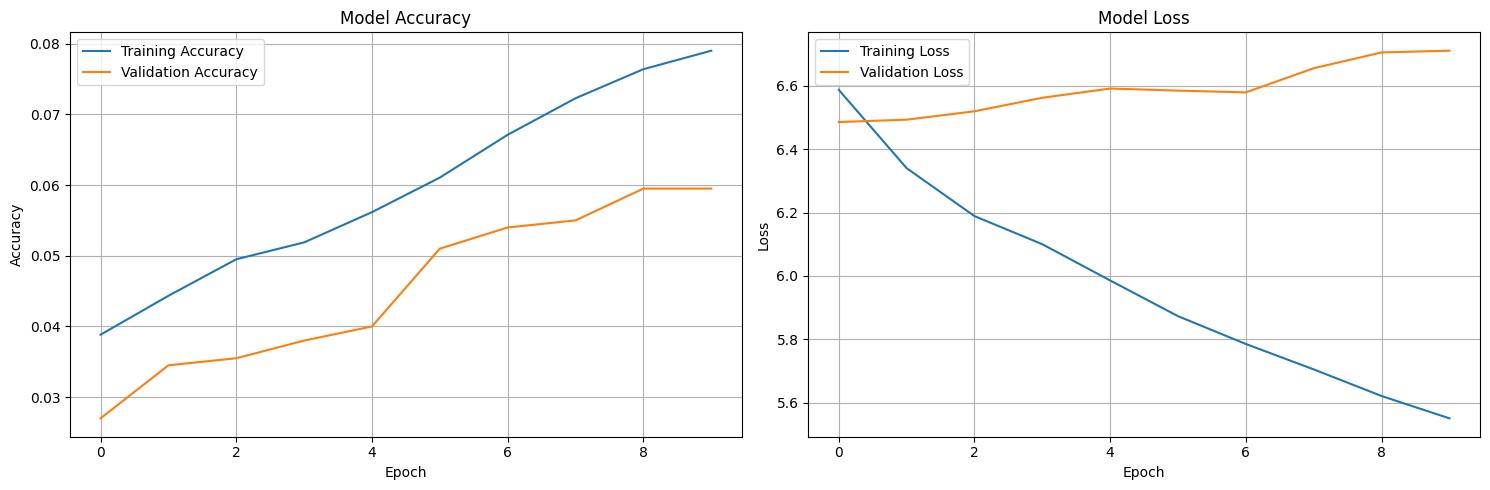

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Experiment 5.3

Import Necessary Libraries

In [ ]:
import json
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


Load the Dataset

In [ ]:
# Import required libraries
import pandas as pd
import json
from tensorflow.keras.datasets import imdb

# Load IMDb dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

# Get the word index
word_index = imdb.get_word_index()

# Create reverse word index for decoding
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Decode reviews to text
def decode_review(text):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text])

# Create DataFrame for training data
train_data = {
    'review': [decode_review(x) for x in X_train],
    'sentiment': y_train
}
df_train = pd.DataFrame(train_data)

# Create DataFrame for test data
test_data = {
    'review': [decode_review(x) for x in X_test],
    'sentiment': y_test
}
df_test = pd.DataFrame(test_data)

# Check the first few rows and columns
print("Training Data:")
print(df_train.head())
print("\nColumns:", df_train.columns)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Data:
                                              review  sentiment
0  ? this film was just brilliant casting locatio...          1
1  ? big hair big boobs bad music and a giant saf...          0
2  ? this has to be one of the worst films of the...          0
3  ? the ? ? at storytelling the traditional sort...          1
4  ? worst mistake of my life br br i picked this...          0

Columns: Index(['review', 'sentiment'], dtype='object')


Clean the Text Data

In [ ]:
import re

def clean_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-z\s.,!?]', '', text)  # Keep basic punctuation for sentiment
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply the cleaning function to the review column
df_train['review'] = df_train['review'].apply(clean_text)
df_test['review'] = df_test['review'].apply(clean_text)

# Check cleaned text
print("Sample cleaned reviews:")
print(df_train['review'].head())

Sample cleaned reviews:
0    ? this film was just brilliant casting locatio...
1    ? big hair big boobs bad music and a giant saf...
2    ? this has to be one of the worst films of the...
3    ? the ? ? at storytelling the traditional sort...
4    ? worst mistake of my life br br i picked this...
Name: review, dtype: object


Tokenize the Text

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Initialize tokenizer with a vocabulary size limit
tokenizer = Tokenizer(num_words=10000)  # Limit to top 10000 most frequent words

# Fit tokenizer on training data only
tokenizer.fit_on_texts(df_train['review'])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(df_train['review'])
test_sequences = tokenizer.texts_to_sequences(df_test['review'])

# Print vocabulary size and sample sequences
print("Vocabulary size:", len(tokenizer.word_index))
print("\nSample sequences from training data:")
print(train_sequences[:3])
print("\nSample sequences from test data:")
print(test_sequences[:3])

Vocabulary size: 9745

Sample sequences from training data:
[[11, 19, 13, 41, 522, 955, 1594, 1359, 62, 451, 4378, 63, 3867, 1, 169, 34, 251, 2, 22, 98, 41, 825, 108, 47, 659, 6, 33, 472, 280, 2, 147, 1, 168, 108, 163, 330, 378, 37, 1, 168, 4444, 1088, 14, 538, 36, 10, 440, 1, 189, 47, 13, 3, 144, 1986, 16, 11, 19, 1, 1877, 4512, 462, 1, 19, 66, 84, 9, 13, 41, 522, 36, 73, 12, 10, 1224, 1, 19, 14, 508, 14, 9, 13, 616, 15, 2, 59, 379, 9, 5, 310, 5, 103, 2, 1, 2189, 5124, 13, 472, 63, 3710, 31, 1, 126, 9, 13, 36, 608, 2, 22, 120, 48, 34, 131, 44, 22, 1387, 31, 3, 19, 9, 211, 25, 74, 49, 2, 11, 401, 13, 79, 5, 1, 104, 113, 903, 12, 251, 1, 4, 3679, 2, 711, 34, 66, 41, 522, 467, 23, 393, 311, 43, 4, 1, 1013, 10, 102, 85, 1, 374, 12, 292, 95, 30, 2033, 53, 23, 137, 3, 191, 7284, 15, 1, 222, 19, 18, 130, 467, 23, 472, 2, 140, 27, 5392, 15, 48, 34, 25, 220, 89, 22, 102, 1, 222, 62, 13, 36, 1310, 85, 9, 13, 279, 2, 13, 4379, 109, 100, 30, 12, 13, 5230, 16, 174, 30], [191, 1133, 191, 7964, 75, 

Pad Sequences

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set maximum sequence length (you can adjust this value)
max_len = 200  # Common length for movie reviews

# Pad sequences for both training and test data
X_train = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

# Print shapes and sample padded sequences
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("\nSample padded sequence from training data:")
print(X_train[0])

Training data shape: (25000, 200)
Test data shape: (25000, 200)

Sample padded sequence from training data:
[  11   19   13   41  522  955 1594 1359   62  451 4378   63 3867    1
  169   34  251    2   22   98   41  825  108   47  659    6   33  472
  280    2  147    1  168  108  163  330  378   37    1  168 4444 1088
   14  538   36   10  440    1  189   47   13    3  144 1986   16   11
   19    1 1877 4512  462    1   19   66   84    9   13   41  522   36
   73   12   10 1224    1   19   14  508   14    9   13  616   15    2
   59  379    9    5  310    5  103    2    1 2189 5124   13  472   63
 3710   31    1  126    9   13   36  608    2   22  120   48   34  131
   44   22 1387   31    3   19    9  211   25   74   49    2   11  401
   13   79    5    1  104  113  903   12  251    1    4 3679    2  711
   34   66   41  522  467   23  393  311   43    4    1 1013   10  102
   85    1  374   12  292   95   30 2033   53   23  137    3  191 7284
   15    1  222   19   18  130  467   23

Prepare Labels (Sarcasm vs. Non-Sarcasm)

In [ ]:
# Extract labels (1 for positive sentiment, 0 for negative sentiment)
y_train = df_train['sentiment'].values
y_test = df_test['sentiment'].values

# Print sample labels and distribution
print("Sample training labels:", y_train[:5])
print("\nLabel distribution in training set:")
print("Positive reviews:", sum(y_train == 1))
print("Negative reviews:", sum(y_train == 0))
print("\nLabel distribution in test set:")
print("Positive reviews:", sum(y_test == 1))
print("Negative reviews:", sum(y_test == 0))

Sample training labels: [1 0 0 1 0]

Label distribution in training set:
Positive reviews: 12500
Negative reviews: 12500

Label distribution in test set:
Positive reviews: 12500
Negative reviews: 12500


Split the Data into Training and Testing Sets

In [ ]:
# Create validation split from training data
from sklearn.model_selection import train_test_split

# Create validation set from training data
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42
)

# Check the shapes of all data splits
print(f"Training data shape: {X_train_final.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

# Verify class distribution in each split
print("\nClass distribution:")
print(f"Training set - Positive: {sum(y_train_final == 1)}, Negative: {sum(y_train_final == 0)}")
print(f"Validation set - Positive: {sum(y_val == 1)}, Negative: {sum(y_val == 0)}")
print(f"Test set - Positive: {sum(y_test == 1)}, Negative: {sum(y_test == 0)}")

Training data shape: (20000, 200)
Validation data shape: (5000, 200)
Test data shape: (25000, 200)

Class distribution:
Training set - Positive: 9937, Negative: 10063
Validation set - Positive: 2563, Negative: 2437
Test set - Positive: 12500, Negative: 12500


Build the LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Build the model
model = Sequential([
    # Embedding layer with increased dimensions
    Embedding(input_dim=vocab_size, output_dim=256, input_length=max_len),
    Dropout(0.3),

    # Bidirectional LSTM layers
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(LSTM(128)),
    Dropout(0.3),

    # Dense layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'AUC']
)

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=0.0001
)

# Train the model with optimized parameters
history = model.fit(
    X_train_final,
    y_train_final,
    epochs=5,                # Reduced epochs
    batch_size=128,         # Increased batch size
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1090s 7s/step - AUC: 0.6541 - accuracy: 0.6096 - loss: 0.6422 - val_AUC: 0.8566 - val_accuracy: 0.7982 - val_loss: 0.4731 - learning_rate: 0.0010
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1099s 7s/step - AUC: 0.8372 - accuracy: 0.7732 - loss: 0.4958 - val_AUC: 0.7799 - val_accuracy: 0.6848 - val_loss: 0.5625 - learning_rate: 0.0010
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1103s 7s/step - AUC: 0.8448 - accuracy: 0.7641 - loss: 0.4853 - val_AUC: 0.8662 - val_accuracy: 0.7836 - val_loss: 0.4657 - learning_rate: 2.0000e-04
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1094s 7s/step - AUC: 0.8973 - accuracy: 0.8229 - loss: 0.4038 - val_AUC: 0.8909 - val_accuracy: 0.8160 - val_loss: 0.4316 - learning_rate: 2.0000e-04
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1116s 7s/step - AUC: 0.9185 - accuracy: 0.8516 - loss: 0.3617 - val_AUC: 0.8856 - val_accuracy: 0.7886 - val_loss: 0.4975 - learning_rate: 2.0000e-04


Evaluate the Model

782/782 ━━━━━━━━━━━━━━━━━━━━ 516s 659ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.84      0.81     12500
    Positive       0.83      0.76      0.79     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



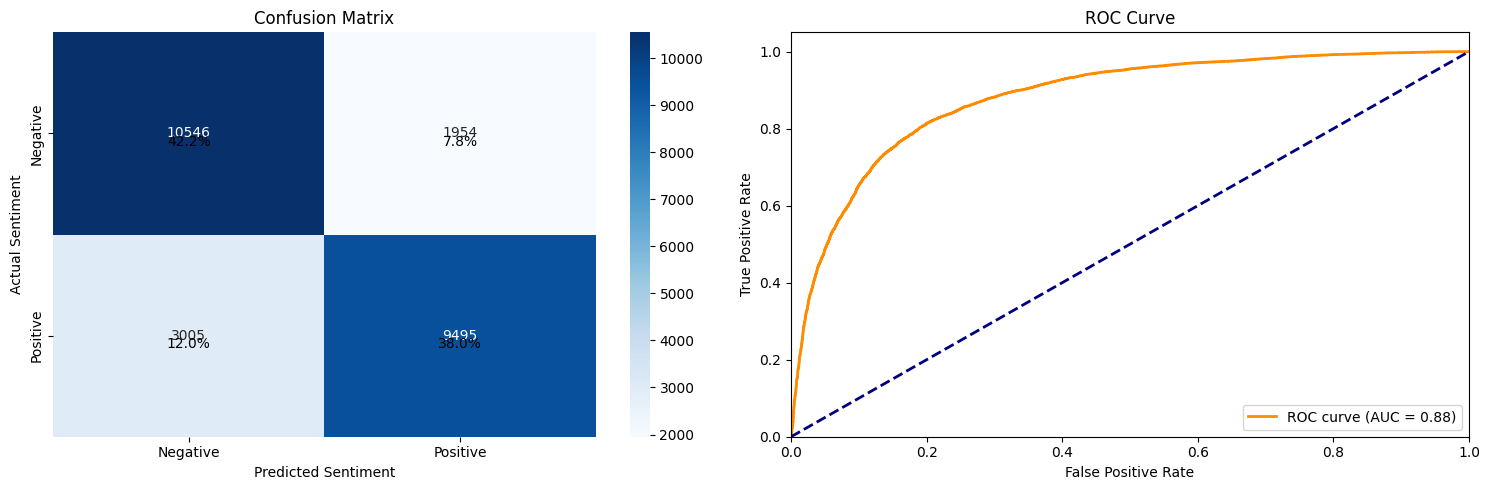

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and probabilities
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype("int32")

# Print detailed metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Create figure with subplots
plt.figure(figsize=(15, 5))

# 1. Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Sentiment")
plt.ylabel("Actual Sentiment")
plt.title("Confusion Matrix")

# Add percentage labels
total = np.sum(cm)
for i in range(2):
    for j in range(2):
        plt.text(j + 0.5, i + 0.5, f'\n{cm[i,j]/total*100:.1f}%',
                ha='center', va='center')

# 2. ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

Visualize Training Performance

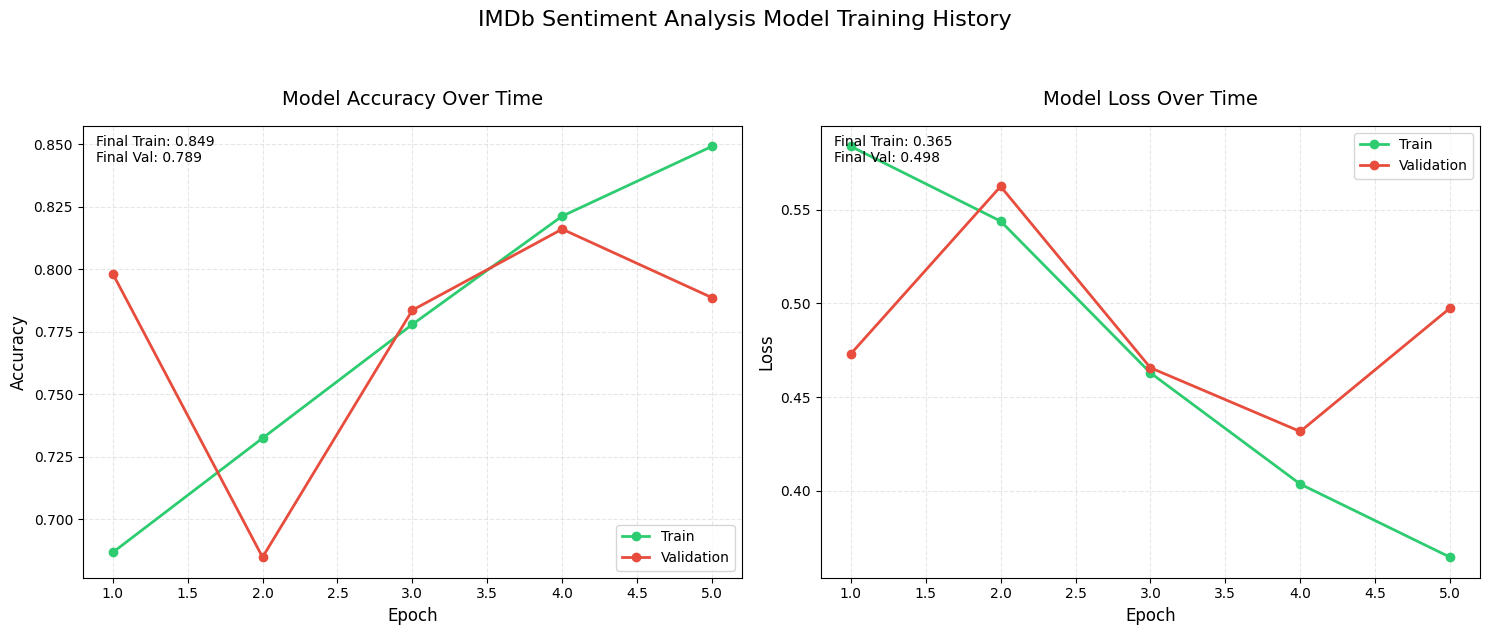

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Set custom style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True

# Accuracy plot
epochs = range(1, len(history.history['accuracy']) + 1)
ax1.plot(epochs, history.history['accuracy'], color='#2ecc71', label='Train', linewidth=2, marker='o')
ax1.plot(epochs, history.history['val_accuracy'], color='#e74c3c', label='Validation', linewidth=2, marker='o')
ax1.set_title("Model Accuracy Over Time", pad=15, fontsize=14)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=10, loc='lower right')

# Add final accuracy values
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
ax1.text(0.02, 0.98, f'Final Train: {final_train_acc:.3f}\nFinal Val: {final_val_acc:.3f}',
         transform=ax1.transAxes, verticalalignment='top', fontsize=10)

# Loss plot
ax2.plot(epochs, history.history['loss'], color='#2ecc71', label='Train', linewidth=2, marker='o')
ax2.plot(epochs, history.history['val_loss'], color='#e74c3c', label='Validation', linewidth=2, marker='o')
ax2.set_title("Model Loss Over Time", pad=15, fontsize=14)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Loss", fontsize=12)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=10, loc='upper right')

# Add final loss values
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
ax2.text(0.02, 0.98, f'Final Train: {final_train_loss:.3f}\nFinal Val: {final_val_loss:.3f}',
         transform=ax2.transAxes, verticalalignment='top', fontsize=10)

plt.suptitle('IMDb Sentiment Analysis Model Training History', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# Save high-quality plot
plt.savefig('imdb_training_history.png', dpi=300, bbox_inches='tight')

Prediction on Real Time data


In [ ]:
def preprocess_text(text, tokenizer, max_len):
    # Clean the text first
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-z\s.,!?]', '', text)  # Keep basic punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    # Tokenize and pad
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    return padded

# Example usage:
sample_review = "This movie was fantastic! The acting was superb."
processed_review = preprocess_text(sample_review, tokenizer, max_len)
prediction = model.predict(processed_review)[0][0]
print(f"Sentiment Score: {prediction:.2f} ({'Positive' if prediction > 0.5 else 'Negative'})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
Sentiment Score: 0.99 (Positive)


In [ ]:
def predict_sentiment(text):
    processed = preprocess_text(text, tokenizer, max_len)
    prediction = model.predict(processed)[0][0]
    label = "Positive 👍" if prediction >= 0.5 else "Negative 👎"
    confidence = prediction if prediction >= 0.5 else 1 - prediction

    print(f"\nReview: {text}")
    print(f"Sentiment Score: {prediction:.4f}")
    print(f"Confidence: {confidence:.2%}")
    print(f"Verdict: {label}")

    return prediction

# Example usage:
reviews = [
    "This movie was absolutely brilliant!",
    "Complete waste of time and money.",
    "It was okay, nothing special."
]

for review in reviews:
    predict_sentiment(review)
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step

Review: This movie was absolutely brilliant!
Sentiment Score: 0.9918
Confidence: 99.18%
Verdict: Positive 👍
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step

Review: Complete waste of time and money.
Sentiment Score: 0.8589
Confidence: 85.89%
Verdict: Positive 👍
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step

Review: It was okay, nothing special.
Sentiment Score: 0.9882
Confidence: 98.82%
Verdict: Positive 👍
--------------------------------------------------


In [ ]:
# Test different types of movie reviews
predict_sentiment("The special effects were incredible and the story kept me on the edge of my seat!")

predict_sentiment("This movie was a complete disaster. Poor acting and terrible script.")

predict_sentiment("While it had some good moments, overall the film was rather disappointing.")

predict_sentiment("The director clearly didn't understand the source material. What a waste.")

predict_sentiment("I can't believe how amazing this film was! Oscar-worthy performances!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step

Review: The special effects were incredible and the story kept me on the edge of my seat!
Sentiment Score: 0.9832
Confidence: 98.32%
Verdict: Positive 👍
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step

Review: This movie was a complete disaster. Poor acting and terrible script.
Sentiment Score: 0.1116
Confidence: 88.84%
Verdict: Negative 👎
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step

Review: While it had some good moments, overall the film was rather disappointing.
Sentiment Score: 0.9870
Confidence: 98.70%
Verdict: Positive 👍
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step

Review: The director clearly didn't understand the source material. What a waste.
Sentiment Score: 0.6081
Confidence: 60.81%
Verdict: Positive 👍
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step

Review: I can't believe how amazing this film was! Oscar-worthy performances!
Sentiment Score: 0.9884
Confidence: 98.84%
Verdict: Positive 👍


np.float32(0.9883612)